In [1]:
import os
import numpy as np
import pandas as pd
import random
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 0
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed)

In [4]:
# Generator untuk DataLoader
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    """Fungsi untuk memastikan setiap worker memiliki seed yang sama"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
images_path_judi = "/kaggle/input/gamblingdet-id/situsjudiid-full/judi"
images_path_non_judi = "/kaggle/input/gamblingdet-id/situsjudiid-full/non-judi"

train_csv_path = '/kaggle/input/train-test/train_data.csv'
test_csv_path = '/kaggle/input/train-test/test_data.csv'

In [6]:
# Load data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
train_df

,File Name,Extracted Text,Class
0,ahoyamigo.com_home.png,KASKUSTOTO LOGIN KASKUSTOTO oiocom KASKUSTOTO ...,judi
1,asgard789.bet.png,SUCKBET kunusn Tusluju Unajv ]acipısı aüns I...,judi
2,bola442.monster.png,AsF User Name Password Code 6636 LOGIN Lela442...,judi
3,maniac-ihokibet.com_page1.png,Download APK Live Chat Hubungı Kamı Lupa Kata ...,judi
4,ketohour.com_page4.png,ketohour Beranda 7 @ Q Subscribe Beranda Situs...,judi
...,...,...,...
3340,bankmandiri.co.id_home.png,Ketik untuk mencari Log In mandırı Perseoranga...,non-judi
3341,bengkaliskab.go.id_page3.png,"JL Ahmad Yani, Bengkalis Kota Selamat datang d...",non-judi
3342,bsmentertainment.com_page9.png,021-22792541 CallWva 08111306600 (Jakarta) | C...,non-judi
3343,coinmarketcap.com_page5.png,CoinMarketCap Cryptocurrencies DexScan Exchang...,non-judi


In [7]:
# Drop missing values
print('Missing values in Train:\n', train_df.isna().sum())
train_df = train_df.dropna()

Missing values in Train:
 File Name         0
Extracted Text    0
Class             0
dtype: int64


In [8]:
import re

def clean_texts(texts):
    cleaned_texts = []

    # Kata 1–2 huruf yang penting dan tidak boleh dihapus
    exceptions = {"di", "ke", "ya", "jl"}

    for text in texts:
        # ----- BASIC CLEANING -----
        text = re.sub(r"http\S+", "", text)                    # Hapus URL
        text = re.sub(r"\n", " ", text)                        # Ganti newline dengan spasi
        text = re.sub(r"[^a-zA-Z]", " ", text)             # Sisakan huruf, angka, apostrof
        text = re.sub(r"\s{2,}", " ", text).strip().lower()    # Hapus spasi ganda & ke lowercase

        # ----- FILTERING -----
        words = text.split()
        filtered_words = [
            w for w in words
            if (len(w) > 2 or w in exceptions)
            and not re.fullmatch(r"[aeiou]{3,}", w)            # Hindari vokal berulang ("aaa")
            and not re.fullmatch(r"[bcdfghjklmnpqrstvwxyz]{3,}", w)  # Hindari konsonan berulang ("kkk")
            and len(w) <= 20                                   # Batasi kata terlalu panjang
        ]

        cleaned_texts.append(" ".join(filtered_words))

    return cleaned_texts

In [9]:
train_df['cleaned_text'] = clean_texts(train_df['Extracted Text'])
test_df['cleaned_text'] = clean_texts(test_df['Extracted Text'])

In [10]:
# Drop rows with less than 5 words
train_df = train_df[train_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
test_df = test_df[test_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
train_df

,File Name,Extracted Text,Class,cleaned_text
0,ahoyamigo.com_home.png,KASKUSTOTO LOGIN KASKUSTOTO oiocom KASKUSTOTO ...,judi,kaskustoto login kaskustoto oiocom kaskustoto ...
1,asgard789.bet.png,SUCKBET kunusn Tusluju Unajv ]acipısı aüns I...,judi,suckbet kunusn tusluju unajv acip augn
2,bola442.monster.png,AsF User Name Password Code 6636 LOGIN Lela442...,judi,asf user name password code login lela live ch...
3,maniac-ihokibet.com_page1.png,Download APK Live Chat Hubungı Kamı Lupa Kata ...,judi,download apk live chat hubung kam lupa kata sa...
4,ketohour.com_page4.png,ketohour Beranda 7 @ Q Subscribe Beranda Situs...,judi,ketohour beranda subscribe beranda situs togel...
...,...,...,...,...
3340,bankmandiri.co.id_home.png,Ketik untuk mencari Log In mandırı Perseoranga...,non-judi,ketik untuk mencari log mand perseorangan bisn...
3341,bengkaliskab.go.id_page3.png,"JL Ahmad Yani, Bengkalis Kota Selamat datang d...",non-judi,jl ahmad yani bengkalis kota selamat datang di...
3342,bsmentertainment.com_page9.png,021-22792541 CallWva 08111306600 (Jakarta) | C...,non-judi,callwva jakarta call wva bandurg office hours ...
3343,coinmarketcap.com_page5.png,CoinMarketCap Cryptocurrencies DexScan Exchang...,non-judi,coinmarketcap cryptocurrencies dexscan exchang...


In [11]:
# Cek jumlah duplikasi sebelum dihapus
print("Duplikasi di train:", train_df.duplicated(subset='cleaned_text').sum())
print("Duplikasi di test :", test_df.duplicated(subset='cleaned_text').sum())

# Hapus duplikasi berdasarkan cleaned_text
train_df = train_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)
test_df = test_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)

# Cek ulang setelah pembersihan
print("Setelah dihapus:")
print("Train:", len(train_df), "baris")
print("Test :", len(test_df), "baris")

Duplikasi di train: 8
Duplikasi di test : 0
Setelah dihapus:
Train: 3335 baris
Test : 700 baris


In [12]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(train_df['Class'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['Class'].value_counts())

Distribusi label di Train set:
Class
non-judi    1740
judi        1595
Name: count, dtype: int64 

Distribusi label di Test set:
Class
judi        350
non-judi    350
Name: count, dtype: int64


In [13]:
from sklearn.utils import resample

# Pisahkan data berdasarkan kelas
train_judi = train_df[train_df['Class'] == 'judi']
train_nonjudi = train_df[train_df['Class'] == 'non-judi']

# Undersampling kelas mayoritas (non-judi) agar jumlahnya sama dengan kelas judi
train_nonjudi_undersampled = resample(train_nonjudi,
                                      replace=False,      # tanpa duplikasi
                                      n_samples=len(train_judi),  # samakan jumlahnya dengan kelas minoritas
                                      random_state=seed)    # untuk replikasi hasil

# Gabungkan kembali data yang sudah diundersample
train_df_balanced = pd.concat([train_judi, train_nonjudi_undersampled])

# Cek distribusi baru
print("Distribusi label setelah undersampling:")
print(train_df_balanced['Class'].value_counts())

Distribusi label setelah undersampling:
Class
judi        1595
non-judi    1595
Name: count, dtype: int64


In [14]:
label_map = {
    "non-judi": 0,
    "judi": 1
}

train_df_balanced['label'] = train_df_balanced['Class'].map(label_map)
test_df['label'] = test_df['Class'].map(label_map)

train_df_balanced['image'] = train_df_balanced['File Name']
test_df['image'] = test_df['File Name']

In [15]:
traindf, validdf = train_test_split(
    train_df_balanced, test_size=0.2, stratify=train_df_balanced['label'], random_state=seed
)

print(f"Jumlah data train: {len(traindf)}")
print(f"Jumlah data valid: {len(validdf)}")
print(f"Jumlah data test: {len(test_df)}")

Jumlah data train: 2552
Jumlah data valid: 638
Jumlah data test: 700


In [16]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(traindf['label'].value_counts(), '\n')

print("Distribusi label di Validation set:")
print(validdf['label'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['label'].value_counts())

Distribusi label di Train set:
label
1    1276
0    1276
Name: count, dtype: int64 

Distribusi label di Validation set:
label
0    319
1    319
Name: count, dtype: int64 

Distribusi label di Test set:
label
1    350
0    350
Name: count, dtype: int64


In [17]:
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

class ResizePadToSquare:
    def __init__(self, target_size=300):
        self.target_size = target_size

    def __call__(self, img):
        img = img.convert("RGB")
        # Resize dengan thumbnail: jaga rasio, resize sisi terpanjang ke target
        img.thumbnail((self.target_size, self.target_size), Image.BILINEAR)
        # Padding agar menjadi square
        delta_w = self.target_size - img.size[0]
        delta_h = self.target_size - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = F.pad(img, padding, fill=0, padding_mode='constant')
        return img


In [18]:
transform_train = transforms.Compose([
    ResizePadToSquare(300),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    ResizePadToSquare(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

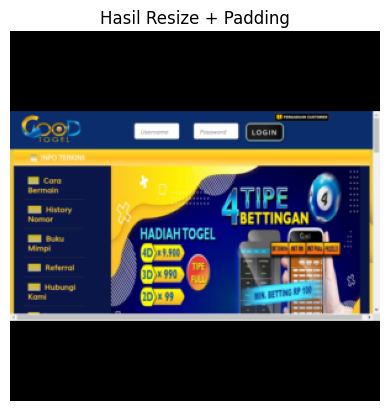

In [19]:
# Ganti path ke gambar
img_path = "/kaggle/input/gamblingdet-id/situsjudiid-full/judi/016-good.pro.png"
img = Image.open(img_path)

# Transform dan lihat hasil
transformed_img = transform_test.transforms[0](img)  # ambil sebelum ToTensor
plt.imshow(transformed_img)
plt.title("Hasil Resize + Padding")
plt.axis('off')
plt.show()

In [20]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_path_judi, images_path_non_judi, transforms=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.images_path_judi = images_path_judi
        self.images_path_non_judi = images_path_non_judi
        self.transforms = transforms
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_name = row['image']
        label = row['label']
        
        # Tentukan path berdasarkan label
        if label == 1:  # judi
            img_path = os.path.join(self.images_path_judi, img_name)
        else:  # non-judi (label == 0)
            img_path = os.path.join(self.images_path_non_judi, img_name)
        
        image = Image.open(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [21]:
# 3. Update inisialisasi dataset
train_dataset = CustomDataset(traindf, images_path_judi, images_path_non_judi, transforms=transform_train)
validation_dataset = CustomDataset(validdf, images_path_judi, images_path_non_judi, transforms=transform_test)
test_dataset = CustomDataset(test_df, images_path_judi, images_path_non_judi, transforms=transform_test)

In [22]:
import time

def run_experiment(optimizer_name, learning_rate, batch_size, device):
    experiment_name = f"{optimizer_name}_lr{learning_rate}_bs{batch_size}"
    print(f"\n===== STARTING EXPERIMENT: {experiment_name} =====\n")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=4, worker_init_fn=seed_worker, generator=g)
    valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, 
                              num_workers=4, worker_init_fn=seed_worker, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=4, worker_init_fn=seed_worker, generator=g)
    
    # Initialize model
    image_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    num_features = image_model.classifier[1].in_features
    image_model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),  # atau 0.5 tergantung eksperimen
        nn.Linear(num_features, 1)
    )

    # image_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    # num_features = image_model.classifier[1].in_features
    # image_model.classifier = nn.Linear(num_features, 1)
    image_model.to(device)
    
    is_parallel = False
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        image_model = nn.DataParallel(image_model)
        is_parallel = True
    
    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(image_model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(image_model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    
    criterion = nn.BCEWithLogitsLoss()

    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    best_val_loss = float('inf')
    best_model_path = f'best_image_model_{experiment_name}_state_dict.pt'
    
    num_epochs = 20
    patience = 5
    counter = 0

    start_total_time = time.time()

    for epoch in range(num_epochs):
        start_epoch_time = time.time()
        
        # TRAIN
        image_model.train()
        total_loss, correct, total_samples = 0.0, 0, 0
        for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images = batch_data['image'].to(device)
            labels = batch_data['label'].float().to(device)

            optimizer.zero_grad()
            outputs = image_model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).long()
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # VALIDATE
        image_model.eval()
        valid_loss, valid_correct, valid_total_samples = 0.0, 0, 0
        with torch.no_grad():
            for batch_data in tqdm(valid_loader, desc=f"Epoch {epoch+1} Validation"):
                images = batch_data['image'].to(device)
                labels = batch_data['label'].float().to(device)
                outputs = image_model(images).squeeze(1)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).long()
                valid_correct += (predicted == labels).sum().item()
                valid_total_samples += labels.size(0)

        valid_epoch_loss = valid_loss / len(valid_loader)
        valid_epoch_accuracy = valid_correct / valid_total_samples
        valid_losses.append(valid_epoch_loss)
        valid_accuracies.append(valid_epoch_accuracy)

        epoch_duration = time.time() - start_epoch_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {valid_epoch_loss:.4f}, Val Acc: {valid_epoch_accuracy:.4f}')
        print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds")

        # Save best model
        if valid_epoch_loss < best_val_loss:
            best_val_loss = valid_epoch_loss
            counter = 0
            torch.save(image_model.module.state_dict() if is_parallel else image_model.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch+1}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    total_training_time = time.time() - start_total_time
    print(f"Total training time: {total_training_time:.2f} seconds")

    # Load best model
    best_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    num_features = best_model.classifier[1].in_features
    best_model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(num_features, 1)
    )
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.to(device)

    # TEST
    test_start_time = time.time()
    metrics = evaluate_image_model(best_model, test_loader, device)
    test_duration = time.time() - test_start_time
    print(f"Test evaluation time: {test_duration:.2f} seconds")
    
    return {
        'experiment_name': experiment_name,
        'metrics': metrics,
        'model_path': best_model_path,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'valid_losses': valid_losses,
        'valid_accuracies': valid_accuracies,
        'best_val_loss': best_val_loss,
        'best_epoch': np.argmin(valid_losses) + 1,
        'stopped_early': counter >= patience,
        'training_time_sec': total_training_time,
        'test_time_sec': test_duration
    }


In [23]:
def evaluate_image_model(model, data_loader, device): 
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="Evaluating Image Model"):
            images = batch_data['image'].to(device)
            labels = batch_data['label'].to(device)
            
            outputs = model(images).squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    metrics = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds)
    }
    
    return metrics

In [24]:
# Define experiments
experiments = [
    # Optimizers: Adam
    {'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 16},
    {'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 32},
    {'optimizer': 'Adam', 'learning_rate': 0.0001, 'batch_size': 16},
    {'optimizer': 'Adam', 'learning_rate': 0.0001, 'batch_size': 32},
    
    # Optimizers: RMSprop
    {'optimizer': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 16},
    {'optimizer': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 32},
    {'optimizer': 'RMSprop', 'learning_rate': 0.0001, 'batch_size': 16},
    {'optimizer': 'RMSprop', 'learning_rate': 0.0001, 'batch_size': 32},
]

In [25]:
# Run all experiments and collect results
results = []
for i, exp in enumerate(experiments):
    print(f"\n\n===== RUNNING EXPERIMENT {i+1}/{len(experiments)} =====")
    print(f"Optimizer: {exp['optimizer']}, Batch Size: {exp['batch_size']}, Learning Rate: {exp['learning_rate']}")
    
    experiment_result = run_experiment(
        optimizer_name=exp['optimizer'],
        learning_rate=exp['learning_rate'],
        batch_size=exp['batch_size'],
        device=device
    )
    
    results.append(experiment_result)
    
    # Print current experiment metrics
    print(f"\n----- Results for Experiment {i+1}: {experiment_result['experiment_name']} -----")
    print(f"Best epoch: {experiment_result['best_epoch']} with validation loss: {experiment_result['best_val_loss']:.4f}")
    if experiment_result.get('stopped_early', False):
        print("Early stopping activated")
    print("Test Metrics:")
    for metric_name, value in experiment_result['metrics'].items():
        print(f"  {metric_name}: {value:.4f}")




===== RUNNING EXPERIMENT 1/8 =====
Optimizer: Adam, Batch Size: 16, Learning Rate: 0.001

===== STARTING EXPERIMENT: Adam_lr0.001_bs16 =====



Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 88.7MB/s]
Epoch 1 Validation: 100%|██████████| 40/40 [00:10<00:00,  3.99it/s]


Epoch [1/20], Train Loss: 0.3337, Train Acc: 0.8664
Epoch [1/20], Val Loss: 0.1963, Val Acc: 0.9216
Epoch 1 duration: 58.09 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


Epoch [2/20], Train Loss: 0.2115, Train Acc: 0.9158
Epoch [2/20], Val Loss: 0.1522, Val Acc: 0.9357
Epoch 2 duration: 54.80 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s]


Epoch [3/20], Train Loss: 0.1329, Train Acc: 0.9510
Epoch [3/20], Val Loss: 0.1511, Val Acc: 0.9404
Epoch 3 duration: 54.69 seconds
New best model saved at epoch 3


Epoch 4 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


Epoch [4/20], Train Loss: 0.1501, Train Acc: 0.9440
Epoch [4/20], Val Loss: 0.1663, Val Acc: 0.9389
Epoch 4 duration: 54.72 seconds


Epoch 5 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.33it/s]


Epoch [5/20], Train Loss: 0.1088, Train Acc: 0.9581
Epoch [5/20], Val Loss: 0.1771, Val Acc: 0.9467
Epoch 5 duration: 54.50 seconds


Epoch 6 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


Epoch [6/20], Train Loss: 0.0942, Train Acc: 0.9683
Epoch [6/20], Val Loss: 0.1386, Val Acc: 0.9561
Epoch 6 duration: 54.34 seconds
New best model saved at epoch 6


Epoch 7 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


Epoch [7/20], Train Loss: 0.0626, Train Acc: 0.9781
Epoch [7/20], Val Loss: 0.2093, Val Acc: 0.9498
Epoch 7 duration: 54.33 seconds


Epoch 8 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


Epoch [8/20], Train Loss: 0.0630, Train Acc: 0.9749
Epoch [8/20], Val Loss: 0.2018, Val Acc: 0.9389
Epoch 8 duration: 54.23 seconds


Epoch 9 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


Epoch [9/20], Train Loss: 0.0792, Train Acc: 0.9730
Epoch [9/20], Val Loss: 0.1957, Val Acc: 0.9420
Epoch 9 duration: 55.20 seconds


Epoch 10 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


Epoch [10/20], Train Loss: 0.0614, Train Acc: 0.9796
Epoch [10/20], Val Loss: 0.2333, Val Acc: 0.9326
Epoch 10 duration: 55.52 seconds


Epoch 11 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


Epoch [11/20], Train Loss: 0.0389, Train Acc: 0.9847
Epoch [11/20], Val Loss: 0.1637, Val Acc: 0.9310
Epoch 11 duration: 55.27 seconds
Early stopping at epoch 11
Total training time: 606.24 seconds


Evaluating Image Model: 100%|██████████| 44/44 [00:10<00:00,  4.06it/s]


Test evaluation time: 10.85 seconds

----- Results for Experiment 1: Adam_lr0.001_bs16 -----
Best epoch: 6 with validation loss: 0.1386
Early stopping activated
Test Metrics:
  Accuracy: 0.9614
  Precision: 0.9736
  Recall: 0.9486
  F1 Score: 0.9609


===== RUNNING EXPERIMENT 2/8 =====
Optimizer: Adam, Batch Size: 32, Learning Rate: 0.001

===== STARTING EXPERIMENT: Adam_lr0.001_bs32 =====



Epoch 1 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [1/20], Train Loss: 0.2924, Train Acc: 0.8926
Epoch [1/20], Val Loss: 0.1828, Val Acc: 0.9310
Epoch 1 duration: 53.75 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch [2/20], Train Loss: 0.1776, Train Acc: 0.9299
Epoch [2/20], Val Loss: 0.1995, Val Acc: 0.9342
Epoch 2 duration: 53.44 seconds


Epoch 3 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [3/20], Train Loss: 0.1278, Train Acc: 0.9526
Epoch [3/20], Val Loss: 0.1904, Val Acc: 0.9342
Epoch 3 duration: 53.46 seconds


Epoch 4 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch [4/20], Train Loss: 0.0922, Train Acc: 0.9639
Epoch [4/20], Val Loss: 0.1667, Val Acc: 0.9483
Epoch 4 duration: 53.38 seconds
New best model saved at epoch 4


Epoch 5 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch [5/20], Train Loss: 0.0868, Train Acc: 0.9647
Epoch [5/20], Val Loss: 0.1394, Val Acc: 0.9483
Epoch 5 duration: 53.81 seconds
New best model saved at epoch 5


Epoch 6 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [6/20], Train Loss: 0.0524, Train Acc: 0.9796
Epoch [6/20], Val Loss: 0.1638, Val Acc: 0.9483
Epoch 6 duration: 53.70 seconds


Epoch 7 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch [7/20], Train Loss: 0.0515, Train Acc: 0.9847
Epoch [7/20], Val Loss: 0.2004, Val Acc: 0.9498
Epoch 7 duration: 54.15 seconds


Epoch 8 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [8/20], Train Loss: 0.0467, Train Acc: 0.9832
Epoch [8/20], Val Loss: 0.2454, Val Acc: 0.9326
Epoch 8 duration: 54.53 seconds


Epoch 9 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [9/20], Train Loss: 0.0320, Train Acc: 0.9886
Epoch [9/20], Val Loss: 0.1822, Val Acc: 0.9592
Epoch 9 duration: 53.74 seconds


Epoch 10 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Epoch [10/20], Train Loss: 0.0354, Train Acc: 0.9855
Epoch [10/20], Val Loss: 0.3788, Val Acc: 0.9185
Epoch 10 duration: 53.63 seconds
Early stopping at epoch 10
Total training time: 538.00 seconds


Evaluating Image Model: 100%|██████████| 22/22 [00:10<00:00,  2.17it/s]


Test evaluation time: 10.14 seconds

----- Results for Experiment 2: Adam_lr0.001_bs32 -----
Best epoch: 5 with validation loss: 0.1394
Early stopping activated
Test Metrics:
  Accuracy: 0.9614
  Precision: 0.9821
  Recall: 0.9400
  F1 Score: 0.9606


===== RUNNING EXPERIMENT 3/8 =====
Optimizer: Adam, Batch Size: 16, Learning Rate: 0.0001

===== STARTING EXPERIMENT: Adam_lr0.0001_bs16 =====



Epoch 1 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [1/20], Train Loss: 0.3860, Train Acc: 0.8342
Epoch [1/20], Val Loss: 0.2022, Val Acc: 0.9279
Epoch 1 duration: 53.16 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


Epoch [2/20], Train Loss: 0.1902, Train Acc: 0.9291
Epoch [2/20], Val Loss: 0.1603, Val Acc: 0.9436
Epoch 2 duration: 53.37 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s]


Epoch [3/20], Train Loss: 0.1199, Train Acc: 0.9565
Epoch [3/20], Val Loss: 0.1562, Val Acc: 0.9373
Epoch 3 duration: 53.14 seconds
New best model saved at epoch 3


Epoch 4 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [4/20], Train Loss: 0.0703, Train Acc: 0.9773
Epoch [4/20], Val Loss: 0.1647, Val Acc: 0.9451
Epoch 4 duration: 53.39 seconds


Epoch 5 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


Epoch [5/20], Train Loss: 0.0575, Train Acc: 0.9835
Epoch [5/20], Val Loss: 0.1692, Val Acc: 0.9451
Epoch 5 duration: 53.45 seconds


Epoch 6 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch [6/20], Train Loss: 0.0478, Train Acc: 0.9851
Epoch [6/20], Val Loss: 0.1630, Val Acc: 0.9467
Epoch 6 duration: 53.40 seconds


Epoch 7 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [7/20], Train Loss: 0.0533, Train Acc: 0.9824
Epoch [7/20], Val Loss: 0.1998, Val Acc: 0.9310
Epoch 7 duration: 53.35 seconds


Epoch 8 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Epoch [8/20], Train Loss: 0.0358, Train Acc: 0.9902
Epoch [8/20], Val Loss: 0.1547, Val Acc: 0.9545
Epoch 8 duration: 53.47 seconds
New best model saved at epoch 8


Epoch 9 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


Epoch [9/20], Train Loss: 0.0162, Train Acc: 0.9953
Epoch [9/20], Val Loss: 0.1184, Val Acc: 0.9514
Epoch 9 duration: 53.62 seconds
New best model saved at epoch 9


Epoch 10 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.44it/s]


Epoch [10/20], Train Loss: 0.0118, Train Acc: 0.9980
Epoch [10/20], Val Loss: 0.1416, Val Acc: 0.9530
Epoch 10 duration: 53.48 seconds


Epoch 11 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.44it/s]


Epoch [11/20], Train Loss: 0.0148, Train Acc: 0.9980
Epoch [11/20], Val Loss: 0.1533, Val Acc: 0.9420
Epoch 11 duration: 53.39 seconds


Epoch 12 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


Epoch [12/20], Train Loss: 0.0088, Train Acc: 0.9976
Epoch [12/20], Val Loss: 0.1537, Val Acc: 0.9561
Epoch 12 duration: 53.83 seconds


Epoch 13 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.42it/s]


Epoch [13/20], Train Loss: 0.0119, Train Acc: 0.9953
Epoch [13/20], Val Loss: 0.1692, Val Acc: 0.9467
Epoch 13 duration: 54.08 seconds


Epoch 14 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [14/20], Train Loss: 0.0233, Train Acc: 0.9957
Epoch [14/20], Val Loss: 0.1798, Val Acc: 0.9436
Epoch 14 duration: 53.25 seconds
Early stopping at epoch 14
Total training time: 749.06 seconds


Evaluating Image Model: 100%|██████████| 44/44 [00:09<00:00,  4.47it/s]


Test evaluation time: 9.87 seconds

----- Results for Experiment 3: Adam_lr0.0001_bs16 -----
Best epoch: 9 with validation loss: 0.1184
Early stopping activated
Test Metrics:
  Accuracy: 0.9729
  Precision: 0.9688
  Recall: 0.9771
  F1 Score: 0.9730


===== RUNNING EXPERIMENT 4/8 =====
Optimizer: Adam, Batch Size: 32, Learning Rate: 0.0001

===== STARTING EXPERIMENT: Adam_lr0.0001_bs32 =====



Epoch 1 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Epoch [1/20], Train Loss: 0.4474, Train Acc: 0.8107
Epoch [1/20], Val Loss: 0.2343, Val Acc: 0.9013
Epoch 1 duration: 55.58 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch [2/20], Train Loss: 0.2025, Train Acc: 0.9212
Epoch [2/20], Val Loss: 0.1706, Val Acc: 0.9373
Epoch 2 duration: 54.85 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [3/20], Train Loss: 0.1156, Train Acc: 0.9604
Epoch [3/20], Val Loss: 0.1529, Val Acc: 0.9420
Epoch 3 duration: 54.37 seconds
New best model saved at epoch 3


Epoch 4 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch [4/20], Train Loss: 0.0725, Train Acc: 0.9745
Epoch [4/20], Val Loss: 0.1573, Val Acc: 0.9451
Epoch 4 duration: 54.12 seconds


Epoch 5 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Epoch [5/20], Train Loss: 0.0608, Train Acc: 0.9769
Epoch [5/20], Val Loss: 0.1407, Val Acc: 0.9483
Epoch 5 duration: 54.12 seconds
New best model saved at epoch 5


Epoch 6 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [6/20], Train Loss: 0.0415, Train Acc: 0.9882
Epoch [6/20], Val Loss: 0.1451, Val Acc: 0.9467
Epoch 6 duration: 54.36 seconds


Epoch 7 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [7/20], Train Loss: 0.0357, Train Acc: 0.9886
Epoch [7/20], Val Loss: 0.1899, Val Acc: 0.9389
Epoch 7 duration: 54.57 seconds


Epoch 8 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [8/20], Train Loss: 0.0210, Train Acc: 0.9941
Epoch [8/20], Val Loss: 0.1636, Val Acc: 0.9420
Epoch 8 duration: 54.36 seconds


Epoch 9 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [9/20], Train Loss: 0.0291, Train Acc: 0.9918
Epoch [9/20], Val Loss: 0.1587, Val Acc: 0.9404
Epoch 9 duration: 54.46 seconds


Epoch 10 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [10/20], Train Loss: 0.0228, Train Acc: 0.9933
Epoch [10/20], Val Loss: 0.1393, Val Acc: 0.9467
Epoch 10 duration: 54.20 seconds
New best model saved at epoch 10


Epoch 11 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [11/20], Train Loss: 0.0138, Train Acc: 0.9976
Epoch [11/20], Val Loss: 0.1426, Val Acc: 0.9451
Epoch 11 duration: 54.18 seconds


Epoch 12 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [12/20], Train Loss: 0.0140, Train Acc: 0.9949
Epoch [12/20], Val Loss: 0.1695, Val Acc: 0.9498
Epoch 12 duration: 54.16 seconds


Epoch 13 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [13/20], Train Loss: 0.0125, Train Acc: 0.9961
Epoch [13/20], Val Loss: 0.1727, Val Acc: 0.9530
Epoch 13 duration: 54.61 seconds


Epoch 14 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [14/20], Train Loss: 0.0117, Train Acc: 0.9973
Epoch [14/20], Val Loss: 0.1748, Val Acc: 0.9514
Epoch 14 duration: 54.81 seconds


Epoch 15 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [15/20], Train Loss: 0.0160, Train Acc: 0.9949
Epoch [15/20], Val Loss: 0.2009, Val Acc: 0.9483
Epoch 15 duration: 54.23 seconds
Early stopping at epoch 15
Total training time: 817.64 seconds


Evaluating Image Model: 100%|██████████| 22/22 [00:10<00:00,  2.14it/s]


Test evaluation time: 10.28 seconds

----- Results for Experiment 4: Adam_lr0.0001_bs32 -----
Best epoch: 10 with validation loss: 0.1393
Early stopping activated
Test Metrics:
  Accuracy: 0.9557
  Precision: 0.9597
  Recall: 0.9514
  F1 Score: 0.9555


===== RUNNING EXPERIMENT 5/8 =====
Optimizer: RMSprop, Batch Size: 16, Learning Rate: 0.001

===== STARTING EXPERIMENT: RMSprop_lr0.001_bs16 =====



Epoch 1 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


Epoch [1/20], Train Loss: 0.4131, Train Acc: 0.8260
Epoch [1/20], Val Loss: 0.2671, Val Acc: 0.9013
Epoch 1 duration: 53.83 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch [2/20], Train Loss: 0.2446, Train Acc: 0.9067
Epoch [2/20], Val Loss: 0.1887, Val Acc: 0.9263
Epoch 2 duration: 53.37 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


Epoch [3/20], Train Loss: 0.2195, Train Acc: 0.9142
Epoch [3/20], Val Loss: 0.2356, Val Acc: 0.9232
Epoch 3 duration: 53.17 seconds


Epoch 4 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


Epoch [4/20], Train Loss: 0.1596, Train Acc: 0.9408
Epoch [4/20], Val Loss: 0.7983, Val Acc: 0.6599
Epoch 4 duration: 53.42 seconds


Epoch 5 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


Epoch [5/20], Train Loss: 0.1583, Train Acc: 0.9377
Epoch [5/20], Val Loss: 0.1576, Val Acc: 0.9342
Epoch 5 duration: 53.62 seconds
New best model saved at epoch 5


Epoch 6 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch [6/20], Train Loss: 0.1152, Train Acc: 0.9592
Epoch [6/20], Val Loss: 0.4167, Val Acc: 0.8746
Epoch 6 duration: 53.17 seconds


Epoch 7 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


Epoch [7/20], Train Loss: 0.0960, Train Acc: 0.9639
Epoch [7/20], Val Loss: 0.2003, Val Acc: 0.9342
Epoch 7 duration: 53.44 seconds


Epoch 8 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


Epoch [8/20], Train Loss: 0.0788, Train Acc: 0.9710
Epoch [8/20], Val Loss: 0.2806, Val Acc: 0.9420
Epoch 8 duration: 53.52 seconds


Epoch 9 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch [9/20], Train Loss: 0.0698, Train Acc: 0.9730
Epoch [9/20], Val Loss: 0.1722, Val Acc: 0.9451
Epoch 9 duration: 53.47 seconds


Epoch 10 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.38it/s]


Epoch [10/20], Train Loss: 0.0686, Train Acc: 0.9722
Epoch [10/20], Val Loss: 0.2461, Val Acc: 0.9342
Epoch 10 duration: 53.62 seconds
Early stopping at epoch 10
Total training time: 535.03 seconds


Evaluating Image Model: 100%|██████████| 44/44 [00:09<00:00,  4.56it/s]


Test evaluation time: 9.67 seconds

----- Results for Experiment 5: RMSprop_lr0.001_bs16 -----
Best epoch: 5 with validation loss: 0.1576
Early stopping activated
Test Metrics:
  Accuracy: 0.9586
  Precision: 0.9625
  Recall: 0.9543
  F1 Score: 0.9584


===== RUNNING EXPERIMENT 6/8 =====
Optimizer: RMSprop, Batch Size: 32, Learning Rate: 0.001

===== STARTING EXPERIMENT: RMSprop_lr0.001_bs32 =====



Epoch 1 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [1/20], Train Loss: 0.4173, Train Acc: 0.8158
Epoch [1/20], Val Loss: 0.2314, Val Acc: 0.8981
Epoch 1 duration: 54.37 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [2/20], Train Loss: 0.2171, Train Acc: 0.9075
Epoch [2/20], Val Loss: 0.1769, Val Acc: 0.9373
Epoch 2 duration: 53.91 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [3/20], Train Loss: 0.1693, Train Acc: 0.9361
Epoch [3/20], Val Loss: 0.1951, Val Acc: 0.9357
Epoch 3 duration: 54.19 seconds


Epoch 4 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


Epoch [4/20], Train Loss: 0.1306, Train Acc: 0.9498
Epoch [4/20], Val Loss: 0.1620, Val Acc: 0.9420
Epoch 4 duration: 54.77 seconds
New best model saved at epoch 4


Epoch 5 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Epoch [5/20], Train Loss: 0.1015, Train Acc: 0.9600
Epoch [5/20], Val Loss: 0.1359, Val Acc: 0.9498
Epoch 5 duration: 54.27 seconds
New best model saved at epoch 5


Epoch 6 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Epoch [6/20], Train Loss: 0.0811, Train Acc: 0.9675
Epoch [6/20], Val Loss: 0.1621, Val Acc: 0.9389
Epoch 6 duration: 53.74 seconds


Epoch 7 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [7/20], Train Loss: 0.0769, Train Acc: 0.9749
Epoch [7/20], Val Loss: 0.1919, Val Acc: 0.9310
Epoch 7 duration: 53.95 seconds


Epoch 8 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [8/20], Train Loss: 0.0522, Train Acc: 0.9820
Epoch [8/20], Val Loss: 0.4108, Val Acc: 0.8903
Epoch 8 duration: 54.13 seconds


Epoch 9 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


Epoch [9/20], Train Loss: 0.0584, Train Acc: 0.9777
Epoch [9/20], Val Loss: 0.1448, Val Acc: 0.9530
Epoch 9 duration: 54.26 seconds


Epoch 10 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [10/20], Train Loss: 0.0502, Train Acc: 0.9816
Epoch [10/20], Val Loss: 0.1570, Val Acc: 0.9514
Epoch 10 duration: 54.31 seconds
Early stopping at epoch 10
Total training time: 542.68 seconds


Evaluating Image Model: 100%|██████████| 22/22 [00:10<00:00,  2.19it/s]


Test evaluation time: 10.06 seconds

----- Results for Experiment 6: RMSprop_lr0.001_bs32 -----
Best epoch: 5 with validation loss: 0.1359
Early stopping activated
Test Metrics:
  Accuracy: 0.9586
  Precision: 0.9820
  Recall: 0.9343
  F1 Score: 0.9575


===== RUNNING EXPERIMENT 7/8 =====
Optimizer: RMSprop, Batch Size: 16, Learning Rate: 0.0001

===== STARTING EXPERIMENT: RMSprop_lr0.0001_bs16 =====



Epoch 1 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


Epoch [1/20], Train Loss: 0.3003, Train Acc: 0.8832
Epoch [1/20], Val Loss: 0.1626, Val Acc: 0.9420
Epoch 1 duration: 53.75 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.44it/s]


Epoch [2/20], Train Loss: 0.1592, Train Acc: 0.9408
Epoch [2/20], Val Loss: 0.1592, Val Acc: 0.9467
Epoch 2 duration: 53.58 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch [3/20], Train Loss: 0.1104, Train Acc: 0.9592
Epoch [3/20], Val Loss: 0.1377, Val Acc: 0.9467
Epoch 3 duration: 53.76 seconds
New best model saved at epoch 3


Epoch 4 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


Epoch [4/20], Train Loss: 0.0606, Train Acc: 0.9820
Epoch [4/20], Val Loss: 0.1476, Val Acc: 0.9467
Epoch 4 duration: 53.69 seconds


Epoch 5 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [5/20], Train Loss: 0.0538, Train Acc: 0.9824
Epoch [5/20], Val Loss: 0.1265, Val Acc: 0.9561
Epoch 5 duration: 53.59 seconds
New best model saved at epoch 5


Epoch 6 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [6/20], Train Loss: 0.0364, Train Acc: 0.9875
Epoch [6/20], Val Loss: 0.1431, Val Acc: 0.9483
Epoch 6 duration: 53.68 seconds


Epoch 7 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch [7/20], Train Loss: 0.0323, Train Acc: 0.9906
Epoch [7/20], Val Loss: 0.1538, Val Acc: 0.9530
Epoch 7 duration: 53.67 seconds


Epoch 8 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.32it/s]


Epoch [8/20], Train Loss: 0.0220, Train Acc: 0.9949
Epoch [8/20], Val Loss: 0.1669, Val Acc: 0.9498
Epoch 8 duration: 53.84 seconds


Epoch 9 Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch [9/20], Train Loss: 0.0269, Train Acc: 0.9918
Epoch [9/20], Val Loss: 0.1692, Val Acc: 0.9467
Epoch 9 duration: 53.16 seconds


Epoch 10 Validation: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


Epoch [10/20], Train Loss: 0.0195, Train Acc: 0.9937
Epoch [10/20], Val Loss: 0.1858, Val Acc: 0.9498
Epoch 10 duration: 53.60 seconds
Early stopping at epoch 10
Total training time: 536.87 seconds


Evaluating Image Model: 100%|██████████| 44/44 [00:09<00:00,  4.54it/s]


Test evaluation time: 9.71 seconds

----- Results for Experiment 7: RMSprop_lr0.0001_bs16 -----
Best epoch: 5 with validation loss: 0.1265
Early stopping activated
Test Metrics:
  Accuracy: 0.9700
  Precision: 0.9687
  Recall: 0.9714
  F1 Score: 0.9700


===== RUNNING EXPERIMENT 8/8 =====
Optimizer: RMSprop, Batch Size: 32, Learning Rate: 0.0001

===== STARTING EXPERIMENT: RMSprop_lr0.0001_bs32 =====



Epoch 1 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch [1/20], Train Loss: 0.2867, Train Acc: 0.8821
Epoch [1/20], Val Loss: 0.1654, Val Acc: 0.9295
Epoch 1 duration: 54.71 seconds
New best model saved at epoch 1


Epoch 2 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [2/20], Train Loss: 0.1378, Train Acc: 0.9510
Epoch [2/20], Val Loss: 0.1598, Val Acc: 0.9342
Epoch 2 duration: 54.78 seconds
New best model saved at epoch 2


Epoch 3 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Epoch [3/20], Train Loss: 0.0731, Train Acc: 0.9745
Epoch [3/20], Val Loss: 0.1667, Val Acc: 0.9373
Epoch 3 duration: 55.17 seconds


Epoch 4 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch [4/20], Train Loss: 0.0569, Train Acc: 0.9804
Epoch [4/20], Val Loss: 0.1526, Val Acc: 0.9451
Epoch 4 duration: 54.23 seconds
New best model saved at epoch 4


Epoch 5 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


Epoch [5/20], Train Loss: 0.0372, Train Acc: 0.9882
Epoch [5/20], Val Loss: 0.1635, Val Acc: 0.9498
Epoch 5 duration: 54.49 seconds


Epoch 6 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Epoch [6/20], Train Loss: 0.0385, Train Acc: 0.9855
Epoch [6/20], Val Loss: 0.1653, Val Acc: 0.9514
Epoch 6 duration: 54.54 seconds


Epoch 7 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


Epoch [7/20], Train Loss: 0.0233, Train Acc: 0.9926
Epoch [7/20], Val Loss: 0.1814, Val Acc: 0.9389
Epoch 7 duration: 54.29 seconds


Epoch 8 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Epoch [8/20], Train Loss: 0.0211, Train Acc: 0.9918
Epoch [8/20], Val Loss: 0.1616, Val Acc: 0.9483
Epoch 8 duration: 54.74 seconds


Epoch 9 Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


Epoch [9/20], Train Loss: 0.0150, Train Acc: 0.9949
Epoch [9/20], Val Loss: 0.2180, Val Acc: 0.9436
Epoch 9 duration: 54.16 seconds
Early stopping at epoch 9
Total training time: 491.49 seconds


Evaluating Image Model: 100%|██████████| 22/22 [00:10<00:00,  2.16it/s]

Test evaluation time: 10.19 seconds

----- Results for Experiment 8: RMSprop_lr0.0001_bs32 -----
Best epoch: 4 with validation loss: 0.1526
Early stopping activated
Test Metrics:
  Accuracy: 0.9671
  Precision: 0.9767
  Recall: 0.9571
  F1 Score: 0.9668


In [26]:
for r in results:
    print(r['experiment_name'])

Adam_lr0.001_bs16
Adam_lr0.001_bs32
Adam_lr0.0001_bs16
Adam_lr0.0001_bs32
RMSprop_lr0.001_bs16
RMSprop_lr0.001_bs32
RMSprop_lr0.0001_bs16
RMSprop_lr0.0001_bs32


In [27]:
# Create a DataFrame for easier analysis
results_df = pd.DataFrame([
    {
        'Experiment': r['experiment_name'],
        'Optimizer': r['experiment_name'].split('_')[0],
        'Learning Rate': float(r['experiment_name'].split('_')[1][2:]),  # remove 'lr'
        'Batch Size': int(r['experiment_name'].split('_')[2][2:]),       # remove 'bs'
        'Best Epoch': r['best_epoch'],
        'Best Val Loss': r['best_val_loss'],
        'Accuracy': r['metrics']['Accuracy'],
        'Precision': r['metrics']['Precision'],
        'Recall': r['metrics']['Recall'],
        'F1 Score': r['metrics']['F1 Score'],
        'Model Path': r['model_path']
    }
    for r in results
])


In [28]:
from datetime import datetime
# Save results to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_csv_path = f'image_model_experiments_results_{timestamp}.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"\nResults saved to {results_csv_path}")


Results saved to image_model_experiments_results_20250803_054138.csv


In [29]:
# Print summary of all experiment results sorted by F1 Score
print("\n===== EXPERIMENT RESULTS SUMMARY (Sorted by F1 Score) =====")
sorted_results = results_df.sort_values('F1 Score', ascending=False)
print(results_df[['Experiment', 'Accuracy', 'Precision', 'Recall','F1 Score']])


===== EXPERIMENT RESULTS SUMMARY (Sorted by F1 Score) =====
              Experiment  Accuracy  Precision    Recall  F1 Score
0      Adam_lr0.001_bs16  0.961429   0.973607  0.948571  0.960926
1      Adam_lr0.001_bs32  0.961429   0.982090  0.940000  0.960584
2     Adam_lr0.0001_bs16  0.972857   0.968839  0.977143  0.972973
3     Adam_lr0.0001_bs32  0.955714   0.959654  0.951429  0.955524
4   RMSprop_lr0.001_bs16  0.958571   0.962536  0.954286  0.958393
5   RMSprop_lr0.001_bs32  0.958571   0.981982  0.934286  0.957540
6  RMSprop_lr0.0001_bs16  0.970000   0.968661  0.971429  0.970043
7  RMSprop_lr0.0001_bs32  0.967143   0.976676  0.957143  0.966811


In [30]:
# Find the best model based on F1 score
best_exp = sorted_results.iloc[0]
print("\n===== BEST MODEL =====")
print(f"Configuration: {best_exp['Experiment']}")
print(f"Batch Size: {best_exp['Batch Size']}")
print(f"Learning Rate: {best_exp['Learning Rate']}")
print(f"Best Epoch: {best_exp['Best Epoch']}")
print(f"F1 Score: {best_exp['F1 Score']:.4f}")
print(f"Accuracy: {best_exp['Accuracy']:.4f}")
print(f"Precision: {best_exp['Precision']:.4f}")
print(f"Recall: {best_exp['Recall']:.4f}")
print(f"Model Path: {best_exp['Model Path']}")


===== BEST MODEL =====
Configuration: Adam_lr0.0001_bs16
Batch Size: 16
Learning Rate: 0.0001
Best Epoch: 9
F1 Score: 0.9730
Accuracy: 0.9729
Precision: 0.9688
Recall: 0.9771
Model Path: best_image_model_Adam_lr0.0001_bs16_state_dict.pt
